In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
from pylab import rcParams

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import scale
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.ensemble import VotingClassifier

import seaborn as sb
sb.set_style('whitegrid')
from collections import Counter

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
train_path = '/kaggle/input/titanic/train.csv'
test_path = '/kaggle/input/titanic/test.csv'
submission_path = '/kaggle/input/titanic/gender_submission.csv'

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
submission_df = pd.read_csv(submission_path)

In [3]:
%matplotlib inline
rcParams['figure.figsize'] = 5, 4

#### Checking that my target var is binary (2 features)

<AxesSubplot:xlabel='Survived', ylabel='count'>

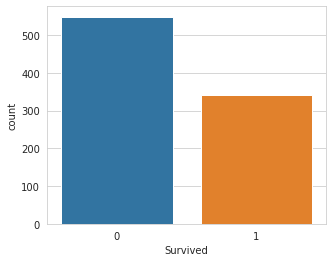

In [4]:
sb.countplot(x='Survived',data=train_df)

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
# It looks like there is missing values. Let's check it (Age,Cabin,Embarked)
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [7]:
train_df.describe()

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200

#### Taking care of missing values

<AxesSubplot:xlabel='Parch', ylabel='Age'>

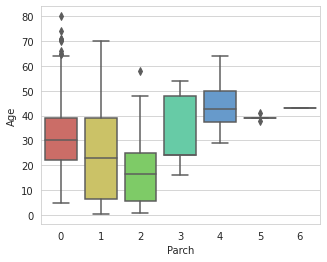

In [8]:
# First of all, Age. If we compare it against Parch we get that we can approximate the missing Age rows with the Parch (parents/children)
sb.boxplot(x='Parch',y='Age',data=train_df,palette='hls')

<AxesSubplot:xlabel='SibSp', ylabel='Age'>

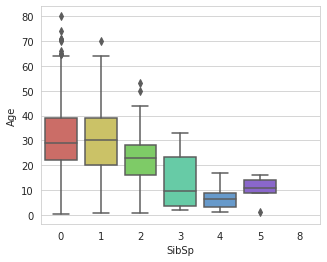

In [9]:
# And against Siblings and Spouse?
sb.boxplot(x='SibSp',y='Age',data=train_df,palette='hls')

In [10]:
parch_age = train_df.groupby('Parch')
parch_age.mean()

PassengerId  Survived    Pclass        Age     SibSp       Fare
Parch                                                                 
0       445.255162  0.343658  2.321534  32.178503  0.237463  25.586774
1       465.110169  0.550847  2.203390  24.422000  1.084746  46.778180
2       416.662500  0.500000  2.275000  17.216912  2.062500  64.337604
3       579.200000  0.600000  2.600000  33.200000  1.000000  25.951660
4       384.000000  0.000000  2.500000  44.500000  0.750000  84.968750
5       435.200000  0.200000  3.000000  39.200000  0.600000  32.550000
6       679.000000  0.000000  3.000000  43.000000  1.000000  46.900000

In [11]:
def age_approx(col):
    Age = col[0]
    Parch = col[1]
    
    if pd.isnull(Age):
        if Parch == 0:
            return 32
        elif Parch == 1:
            return 24
        elif Parch == 2:
            return 17
        elif Parch == 3:
            return 33
        elif Parch == 4:
            return 45
        else:
            return 30
    else:
        return Age

In [12]:
train_df['Age'] = train_df[['Age','Parch']].apply(age_approx,axis=1)
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

#### Dropping unnecesary values such as "ticket or cabin" and NaN rows

In [13]:
# I don't really see any impact on survival rate with these 2 features
train_df = train_df.drop(['Ticket','Cabin'], axis=1)

# Since it's only 2 values missing from Embarked we can drop them
train_df.dropna(inplace=True)
# In order to have an accurate index we should reset it
train_df.reset_index(inplace=True,drop=True)

print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Name         889 non-null    object 
 4   Sex          889 non-null    object 
 5   Age          889 non-null    float64
 6   SibSp        889 non-null    int64  
 7   Parch        889 non-null    int64  
 8   Fare         889 non-null    float64
 9   Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(3)
memory usage: 69.6+ KB
None


#### Converting categorical variables to a dummy indicators

In [14]:
# from sklearn.preprocessing import LabelEncoder (first line)
# 1 - Gender
label_encoder = LabelEncoder()
gender_cat = train_df['Sex']
gender_encoder = label_encoder.fit_transform(gender_cat)
gender_encoder[0:5]

array([1, 0, 0, 0, 1])

In [15]:
# 1 = male, 0 = female
train_df.head(3)

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   

   Parch     Fare Embarked  
0      0   7.2500        S  
1      0  71.2833        C  
2      0   7.9250        S

In [16]:
# Creating a gender DataFrame
gender_df = pd.DataFrame(gender_encoder, columns=['male_gender'])

In [17]:
# 2 - Embarked
embarked_cat = train_df['Embarked']
embarked_encoder = label_encoder.fit_transform(embarked_cat)
embarked_encoder[0:100]

array([2, 0, 2, 2, 2, 1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 1, 2, 2, 0, 2, 2,
       1, 2, 2, 2, 0, 2, 1, 2, 0, 0, 1, 2, 0, 2, 0, 2, 2, 0, 2, 2, 0, 0,
       1, 2, 1, 1, 0, 2, 2, 2, 0, 2, 0, 2, 2, 0, 2, 2, 0, 2, 2, 0, 0, 2,
       2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2])

In [18]:
# We can see 3 numbers corresponding to the 3 ports so this is a multi-nominal var. 
# We need 'Embarked' to be represented by binary vars: One-Hot Encoder
# from sklearn.preprocessing import OneHotEncoder
binary_encoder = OneHotEncoder(categories='auto')
embarked_1hot = binary_encoder.fit_transform(embarked_encoder.reshape(-1,1)) # reshape to a single col
embarked_1hot_mat = embarked_1hot.toarray()
embarked_df = pd.DataFrame(embarked_1hot_mat, columns = ['C','Q','S'])
embarked_df.head()

C    Q    S
0  0.0  0.0  1.0
1  1.0  0.0  0.0
2  0.0  0.0  1.0
3  0.0  0.0  1.0
4  0.0  0.0  1.0

In [19]:
# We don't need anymore the orignial Titanic df with sex and embarked
train_df.drop(['Sex','Embarked'], axis=1, inplace=True)
train_df.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name   Age  SibSp  Parch  \
0                            Braund, Mr. Owen Harris  22.0      1      0   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  38.0      1      0   
2                             Heikkinen, Miss. Laina  26.0      0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  35.0      1      0   
4                           Allen, Mr. William Henry  35.0      0      0   

      Fare  
0   7.2500  
1  71.2833  
2   7.9250  
3  53.1000  
4   8.0500

In [20]:
# Concatenate our new var to the df
train_dmy = pd.concat([train_df, gender_df,embarked_df], axis=1, verify_integrity=True)
train_dmy[0:5]

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name   Age  SibSp  Parch  \
0                            Braund, Mr. Owen Harris  22.0      1      0   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  38.0      1      0   
2                             Heikkinen, Miss. Laina  26.0      0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  35.0      1      0   
4                           Allen, Mr. William Henry  35.0      0      0   

      Fare  male_gender    C    Q    S  
0   7.2500            1  0.0  0.0  1.0  
1  71.2833            0  1.0  0.0  0.0  
2   7.9250            0  0.0  0.0  1.0  
3  53.1000            0  0.0  0.0  1.0  
4   8.0500            1  0.0  0.0  1.0

#### Checking for independence between features

<AxesSubplot:>

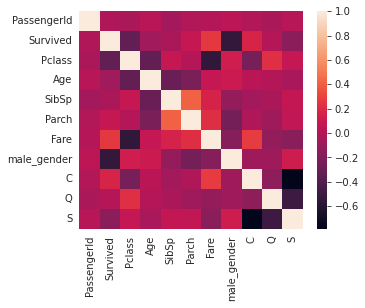

In [21]:
# Heatmap from Seaborn bc is very easy to visualise the dependency with this tool
sb.heatmap(train_dmy.corr())

In [22]:
# Logistic Regression assumes that features are independent of one another, so we cannot have a corr that's close to one or negative one (meaning, strong linear relation)
# What values are very light or very dark? We can see Fare and P-Class are not independent of one another so we drop them

train_dmy.drop(['Fare','Pclass'], axis = 1, inplace=True) # axis = 1 bc we want to drop them as a column
train_dmy.head(3)

PassengerId  Survived                                               Name  \
0            1         0                            Braund, Mr. Owen Harris   
1            2         1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2            3         1                             Heikkinen, Miss. Laina   

    Age  SibSp  Parch  male_gender    C    Q    S  
0  22.0      1      0            1  0.0  0.0  1.0  
1  38.0      1      0            0  1.0  0.0  0.0  
2  26.0      0      0            0  0.0  0.0  1.0

In [23]:
def name_preprocess(name):
    name_df = pd.DataFrame(index=name.index)

    name_df["Title"] = name.map(lambda x: x.split(', ')[1].split('. ')[0])
    name_df['Title'].replace(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer', inplace=True)
    name_df['Title'].replace(['Don', 'Sir',  'the Countess', 'Lady', 'Dona'], 'Royalty', inplace=True)
    name_df['Title'].replace(['Mme', 'Ms','Mlle'], 'Civil(Mrs/Miss)', inplace=True) # We already know the gender, there is no need of having 2 cols
    name_df['Title'].replace(['Jonkheer'], 'Master', inplace=True)

    Surname = name.map(lambda name:name.split(',')[0].strip())
    count_df_over2 = Surname.value_counts().to_frame()
    count_df_over2 = count_df_over2[count_df_over2["Name"]>1]
    name_df['Family_flag'] = Surname.map(lambda x:1 if x in list(count_df_over2.index) else 0)
    name_df = pd.get_dummies(name_df)
    return name_df

In [24]:
df_Name = name_preprocess(train_dmy["Name"])
train_dmy = pd.concat([train_dmy, df_Name],axis=1)
train_dmy = train_dmy.drop("Name",axis=1)
train_dmy.head(4)

PassengerId  Survived   Age  SibSp  Parch  male_gender    C    Q    S  \
0            1         0  22.0      1      0            1  0.0  0.0  1.0   
1            2         1  38.0      1      0            0  1.0  0.0  0.0   
2            3         1  26.0      0      0            0  0.0  0.0  1.0   
3            4         1  35.0      1      0            0  0.0  0.0  1.0   

   Family_flag  Title_Civil(Mrs/Miss)  Title_Master  Title_Miss  Title_Mr  \
0            1                      0             0           0         1   
1            0                      0             0           0         0   
2            0                      0             0           1         0   
3            1                      0             0           0         0   

   Title_Mrs  Title_Officer  Title_Royalty  
0          0              0              0  
1          1              0              0  
2          0              0              0  
3          1              0              0

In [25]:
# Time for a Logistic Regression
# We drop "survived" bc is what we are actually trying to predict
X_train, X_test, y_train, y_test = train_test_split(train_dmy.drop('Survived', axis=1),
                                                   train_dmy['Survived'], test_size=0.2,
                                                   random_state=200)

In [26]:
print(X_train.shape)
print(y_train.shape)

(711, 16)
(711,)


#### Deploying and evaluating the model

In [27]:
logreg = LogisticRegression(solver='liblinear')
logreg.fit(X_train,y_train)

LogisticRegression(solver='liblinear')

In [28]:
y_pred = logreg.predict(X_test)

### Model Evalutation
#### Classification report w/o cross-validation

In [29]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88       109
           1       0.83      0.77      0.80        69

    accuracy                           0.85       178
   macro avg       0.84      0.83      0.84       178
weighted avg       0.85      0.85      0.85       178



#### K-fold cross-validation & confusion matrix

In [30]:
y_train_pred = cross_val_predict(logreg, X_train, y_train, cv=5)
confusion_matrix(y_train, y_train_pred)

array([[384,  56],
       [ 77, 194]])

We get 384 / 194 correct predictions and 77 / 56 incorrect predictions

In [31]:
precision_score(y_train, y_train_pred)

0.776

## Ensemble Learning
##### Train different models on the same dataset

In [32]:
# Voting Classifier (same trainset, different algorithm)
# N classifiers make P predictions
# from sklearn.ensamble import VotingClassifier

In [33]:
SEED = 1
lr = LogisticRegression()